In [432]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.random.seed(1)

In [433]:
N = 6
# Testing vector
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 2] = 0.5
cables[2,3] = 0.5
bars[3, 4] = 0.5
bars[4,5] = 1
#bars[0,5] = 0.5
"""bars[0, 6] = 0.5
bars[6, 7] = 5
bars[3, 8] = 1
cables[8, 9] = 1"""

'bars[0, 6] = 0.5\nbars[6, 7] = 5\nbars[3, 8] = 1\ncables[8, 9] = 1'

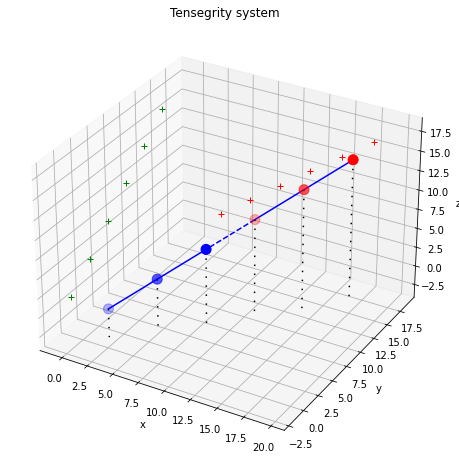

[[-1.75, 20.75], [-2.75, 19.75], [-3.75, 18.75]]

In [434]:
def plot_points(X, bars, cables, M, lims = [None, None, None], title = "Tensegrity system"):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection = '3d')
    ax.set_title(title)
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    
    xlims, ylims, zlims = lims
    if xlims == None:
        xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
        xlims = [xmin - (xmax-xmin) / 4, xmax + (xmax-xmin) / 4]
    if ylims == None:
        ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
        ylims = [ymin - (ymax-ymin) / 4, ymax + (ymax-ymin) / 4]
    if zlims == None:
        zmin, zmax = np.min(X[:,2]), np.max(X[:,2])
        zlims = [zmin - (zmax-zmin) / 4, zmax + (zmax-zmin) / 4]

    ax.scatter(x[:M], y[:M], z[:M], s = 100, c = 'red')
    ax.scatter(x[M:], y[M:], z[M:], s = 100, c = 'blue')

    ax.plot(x, z, 'r+', zdir='y', zs = ylims[1])
    ax.plot(y, z, 'g+', zdir='x', zs= xlims[0])
    #ax.plot(x, y, 'k+', zdir='z', zs= zmin - (zmax-zmin) / 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim3d(xlims[0], xlims[1])
    ax.set_ylim3d(ylims[0], ylims[1])
    ax.set_zlim3d(zlims[0], zlims[1])

    cable_indices = np.asarray(np.where(cables != 0))
    for i, j in cable_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b--')

    bar_indices = np.asarray(np.where(bars != 0))
    for i, j in bar_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b-')

    # Projection down on z
    for i in range(len(z)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], zlims[0]], linestyle = (0, (1, 5)), color = 'black')
    plt.show() 
    return [xlims, ylims, zlims]

plot_points(X, bars, cables, 3)

## Energy functions

In [435]:
g = 9.81
def E_ext(X, ms, consts):
    g = consts[0]
    return g * np.sum(ms * X[:, 2])


def E_bar(X, bars, consts):
    g, rho, c, k = consts
    bars_indices = np.asarray(np.where(bars != 0))
    grav = 0
    elast = 0
    for i, j in bars_indices.T:
        grav += bars[i, j] * (X[i, 2] + X[j, 2])
        elast += (np.linalg.norm(X[i] - X[j]) - bars[i, j])**2 / bars[i, j]**2
    return rho * g * grav / 2 + c / 2 *  elast

def E_cable(X, cables, consts):
    k = consts[3]
    cables_indices = np.asarray(np.where(cables != 0))
    energy = 0
    for i, j in cables_indices.T:
        if np.linalg.norm(X[i] - X[j]) > cables[i, j]:
            energy += (np.linalg.norm(X[i] - X[j]) - cables[i, j])**2 / cables[i, j]**2
    return energy * k / 2 

def E(X, cables, bars, ms, consts):
    Y = X.reshape(len(ms), 3)
    return E_ext(Y, ms, consts) + E_bar(Y, bars, consts) + E_cable(Y, cables, consts)

# Test
g, rho, c, k = 9.81, 1, 1, 1
consts = [g, rho, c, k]
ms = 0.1 * np.ones(N)
print(E(X, cables, bars, ms, consts))

383.88712819564034


In [436]:
a = np.arange(9).reshape((3,3))
print(a)
print(np.vstack((-a,a)))
print(a.flatten())
print(a.flatten()[2::3])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ 0 -1 -2]
 [-3 -4 -5]
 [-6 -7 -8]
 [ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]]
[0 1 2 3 4 5 6 7 8]
[2 5 8]


### Derivative of energy functions

In [437]:
def dE_ext(X, ms, P, N, M, consts):
    g = consts[0]
    deriv = np.zeros(3 * (N - M))
    deriv[2::3] = ms[M:]
    return g * deriv.flatten()
#np.concatenate((np.zeros((N, 2)), ms)).flatten()

def dE_bar(Y, bars, P, N, M, consts):
    g, rho, c, k = consts
    bars_indices = np.asarray(np.where(bars != 0))
    grav = np.zeros((N, 3))
    elast = np.zeros((N, 3))
    if P.size > 0:
        X = np.vstack((P, Y))
    else:
        X = Y
    for i, j in bars_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        grav[i] += np.array([0, 0, bars[i, j]])
        grav[j] += np.array([0, 0, bars[i, j]])
        elast[i] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
        elast[j] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])

    return rho * g * grav[M:].flatten() / 2 + c *  elast[M:].flatten()

def dE_cable(Y, cables, P, N, M, consts):
    k = consts[3]
    cable_indices = np.asarray(np.where(cables != 0))
    elast = np.zeros((N, 3))
    if P.size > 0:
        X = np.vstack((P, Y))
    else:
        X = Y
    for i, j in cable_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        if norm > cables[i, j]:
            elast[i] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
            elast[j] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])
    return k * elast[M:].flatten()

def dE(X, P, cables, bars, ms, N, M, consts):
    Y = X.reshape(N - M, 3)
    gradient = (dE_ext(Y, ms, P, N, M, consts) + dE_bar(Y, bars, P, N, M, consts) + dE_cable(Y, cables, P, N, M, consts))
    return gradient
M = 1
print(dE(X[M:], X[:M], cables, bars, ms, N, M, consts))

[ 0.          0.          5.886       0.          0.          3.4335
  0.          0.          3.4335     -8.42264973 -8.42264973 -0.08414973
 -2.42264973 -2.42264973  3.46335027]


### Backtracking

In [438]:
def armijo(x, alpha, p, c1, f, df):
    return f(x + alpha * p) <= f(x) + c1 * alpha * np.inner(df(x), p)

def curvature(x, alpha, p, c2, df):
    return -np.inner(df(x + alpha * p), p) <= -c2 * np.inner(df(x), p)

def backtracking(x, p, c1, c2, f, df, maxiter = 100):
    assert(c1 < c2)
    alpha_min, alpha_max = 0, np.inf
    alpha = 5
    I = armijo(x, alpha, p, c1, f, df)
    II = curvature(x, alpha, p, c2, df)
    iter = 0
    while not (I and II):
        if iter > maxiter:
            break
        if not I:
            alpha_max = alpha
            alpha = (alpha_min + alpha_max) / 2
        else:
            alpha_min = alpha
            if alpha_max < np.inf:
                alpha = (alpha_min + alpha_max) / 2
            else:
                alpha *= 2
        I = armijo(x, alpha, p, c1, f, df)
        II = curvature(x, alpha, p, c2, df)
        #print(alpha, I, II)
        iter += 1
    return alpha

def backtracking2(x, p, c1, ro, f, df):
    alpha = 10
    while not armijo(x, alpha, p, c1, f, df):
        alpha *= ro
    return alpha

### Test case

[17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0] [17 16 15] [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


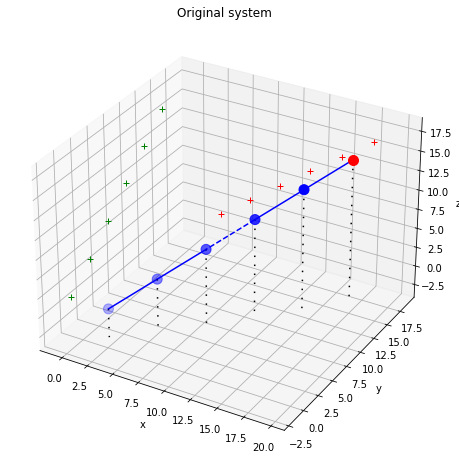

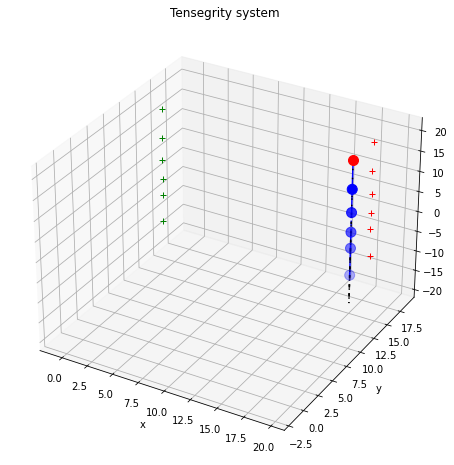

array([ 16.99958635,  15.99958635,   7.75578372,  16.99915906,
        15.99915906,   1.9830701 ,  16.99879921,  15.99879921,
        -2.9313616 ,  16.99855429,  15.99855429,  -6.98733435,
        16.99788522,  15.99788522, -13.8731441 ])

In [439]:
def BFGS(X0, N, M, cables, bars, maxiter, f, df, keep_limits = False):
    original_limits = plot_points(X0.reshape((N,3)), bars, cables, M, title = 'Original system')
    P = X0[:3 * M]
    Y0 = X0[3 * M:]

    c1, c2 = 0.025, 0.2
    # First: Gradient descent
    p = -df(Y0)
    #alpha = backtracking(Y0, p, c1, c2, f, df)
    alpha = backtracking(Y0, p, c1, c2, f, df)
    Y1 = Y0 + alpha * p

    sk = Y1 - Y0
    yk = df(Y1) - df(Y0)
    H = np.inner(yk, sk) / np.inner(yk, yk) * np.eye(3 * (N - M))

    for k in range(maxiter):
        #p = -H @ df(Y1)
        p = -df(Y1)
        
        #print("Inner", np.inner(df(Y1), p))
        #alpha = backtracking(Y1, p, c1, c2, f, df)
        alpha = backtracking(Y1, p, c1, c2, f, df)
        #print(alpha, f(Y1))
        Y0 = Y1
        Y1 = Y0 + alpha * p
        
        sk = Y1 - Y0
        yk = df(Y1) - df(Y0)
        Hkyk = H@yk
        Sk = 1 / np.inner(sk, yk)
        H = H - Sk * (sk @ Hkyk.T + Hkyk @ sk.T) + sk @ sk.T * (Sk**2 * np.inner(yk, Hkyk) + Sk)
    
    if not keep_limits:
        original_limits = [None, None, None]
    
    original_limits[2] = None
    plot_points((np.concatenate((P, Y1))).reshape(N, 3), bars, cables, M, lims = original_limits)
    return Y1

N = 6
M = 1
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 2] = 0.5
cables[2,3] = 0.5
bars[3, 4] = 0.5
bars[4,5] = 1

X0 = X.flatten()
P = X0[:3 * M]
Y0 = X0[3 * M:]

def f(y):
    X = np.concatenate((P, y))
    return E(X, cables, bars, ms, consts)
def df(y):
    return dE(y, P.reshape(M, 3), cables, bars, ms, N, M, consts)

BFGS(X0, N, M, cables, bars, 100, f, df, keep_limits = True)

## Cable system where solution is known

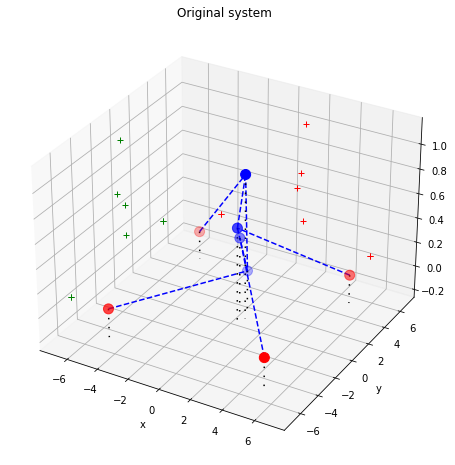

<ipython-input-439-9f77dae07f2d>:31: RuntimeWarning: divide by zero encountered in scalar divide
  Sk = 1 / np.inner(sk, yk)
<ipython-input-439-9f77dae07f2d>:32: RuntimeWarning: invalid value encountered in scalar multiply
  H = H - Sk * (sk @ Hkyk.T + Hkyk @ sk.T) + sk @ sk.T * (Sk**2 * np.inner(yk, Hkyk) + Sk)


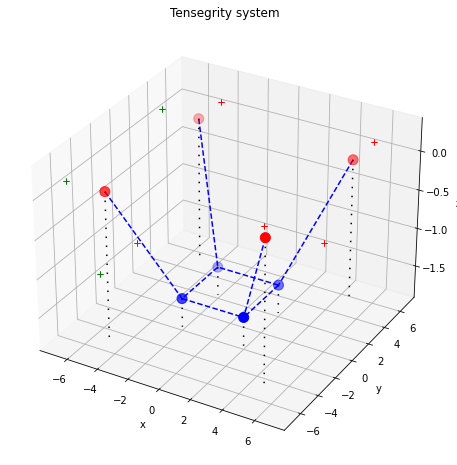

[[ 2.   2.  -1.5]
 [-2.   2.  -1.5]
 [-2.  -2.  -1.5]
 [ 2.  -2.  -1.5]]


In [445]:
g, rho, c, k = 9.81, 1, 1, 3
consts = [g, rho, c, k]
N = 8
M = 4
P = np.array([[5, 5, 0],
              [-5, 5, 0],
              [-5, -5, 0],
              [5, -5, 0]])
Y0 = np.random.rand(N-M, 3)
X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))
cables[0, 4], cables[1, 5], cables[2, 6], cables[3, 7], cables[4, 5], cables[4, 7], cables[5, 6], cables[6, 7] = [3] * 8

ms = np.ones(N) / (6 * g)

def f(y):
    X = np.concatenate((P.flatten(), y))
    return E(X, cables, bars, ms, consts)

def df(y):
    return dE(y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 100, f, df,)
#Y = BFGS(X0.flatten(), N, M, cables, bars, ms, 100, consts)
print(Y.reshape((N-M, 3)))


## Test case with cables and bars

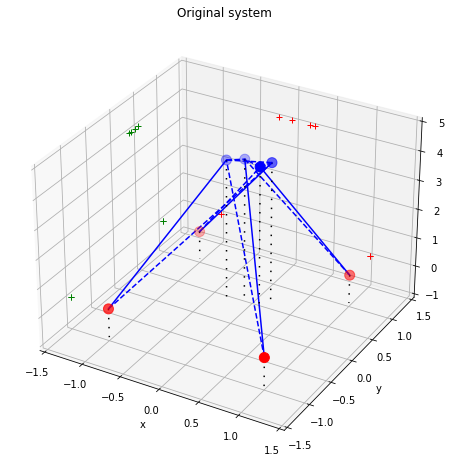

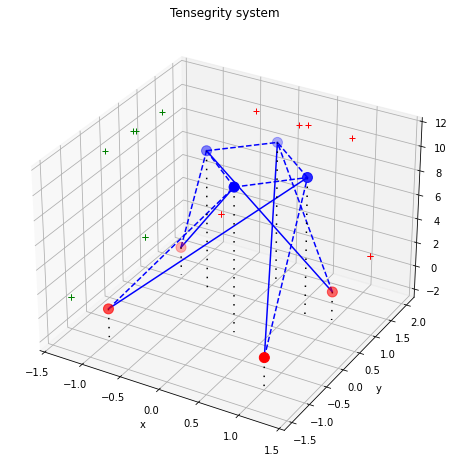

0.6613098872556885
0.009285570258758234


In [443]:
g, rho, c, k = 0, 0, 1, 0.1
consts = [g, rho, c, k]
N = 8
M = 4
P = np.array([[1, 1, 0],
              [-1, 1, 0],
              [-1, -1, 0],
              [1, -1, 0]])
Y0 = np.random.rand(N-M, 3) - 0.5
Y0[:, 2] = 4
P[0, 2] = 0.5
X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))

bars[0, 4], bars[1, 5], bars[2, 6], bars[3, 7] = [10] * 4
cables[0, 7], cables[1, 4], cables[2, 5], cables[3, 6] = [8] * 4
cables[4, 5], cables[4, 7], cables[5, 6], cables[6, 7] = [1] * 4

ms = np.zeros(N)

def f(y):
    X = np.concatenate((P.flatten(), y))
    return E(X, cables, bars, ms, consts)

def df(y):
    return dE(y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 100, f, df)

Y = Y.reshape((N-M, 3))
s, t = 0.70970, 9.54287
Ystar = np.array([[-s,0,t], 
               [0, -s, t],
               [s,0,t],
               [0,s,t]])

print(E(np.vstack((P, Y0)), cables, bars, ms, consts))
print(E(np.vstack((P, Ystar)), cables, bars, ms, consts))


### Tensegrity table

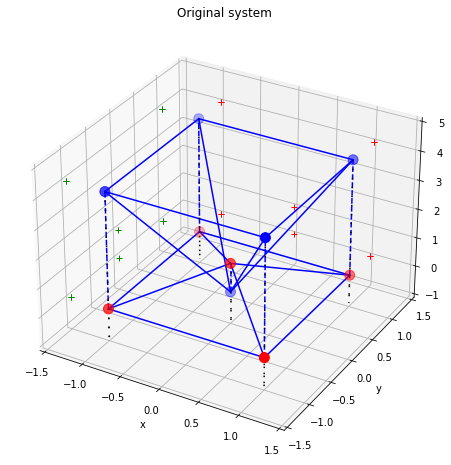

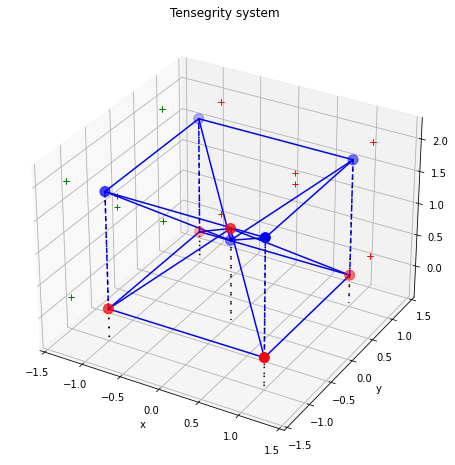

[[ 0.99954917  0.99954917  1.81491396]
 [-0.99954917  0.99954917  1.81491396]
 [-0.99954917 -0.99954917  1.81491396]
 [ 0.99954917 -0.99954917  1.81491396]
 [ 0.          0.          0.81605235]]


In [444]:
g, rho, c, k = 9.81, 0, 10, 10
consts = [g, rho, c, k]
N = 10
M = 5
P = np.array([[1, 1, 0],
              [-1, 1, 0],
              [-1, -1, 0],
              [1, -1, 0],
              [0, 0, 1]])
Y0 = np.random.rand(N-M, 3) - 0.5
Y0 = np.copy(P)
Y0[:, 2] += 4
Y0[-1, 2] = np.sqrt(2) - 1

X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))

bars[0, 1], bars[1, 2], bars[2, 3], bars[0, 3] = [2] * 4
bars[0, 4], bars[1, 4], bars[2, 4], bars[3, 4] = [np.sqrt(3)] * 4

bars[5, 6], bars[6, 7], bars[7, 8], bars[5, 8] = [2] * 4
bars[5, 9], bars[6, 9], bars[7, 9], bars[8, 9] = [np.sqrt(3)] * 4

cables[0, 5], cables[1, 6], cables[2, 7], cables[3, 8] = [2] * 4
cables[4, 9] = 2*np.sqrt(2) - 2

ms = 0.001 * np.ones(N)

def f(y):
    X = np.concatenate((P.flatten(), y))
    return E(X, cables, bars, ms, consts)

def df(y):
    return dE(y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 100, f, df)
Y = Y.reshape((N-M, 3))

## With ground- Logarithmic barriers

In [ ]:
def constraints(X):
    return np.sum(X[2::3])

def B(X, beta, cables, bars, ms, consts):
    N = len(ms)
    return E(X, cables, bars, ms, consts) - beta * np.sum(np.log(constraints(X)))

def dB(X, beta, cables, bars, ms, consts):
    barrier = np.zeros(X.shape).flatten()
    barrier[2::3] = -beta * 1 / X[2::3]
    return dE(X, np.array([]), cables, bars, ms, N, 0, consts) + barrier

N = 6
# Testing vector
ms = np.ones(N)
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

beta = 0.01
print(B(X.flatten(), beta, cables, bars, ms, consts))
print(dB(X.flatten(), beta, cables, bars, ms, consts))

441.41193337510236
[0.         0.         9.80933333 0.         0.         9.80916667
 0.         0.         9.80888889 0.         0.         9.80833333
 0.         0.         9.80666667 0.         0.               -inf]


<ipython-input-394-6d47020d0a79>:10: RuntimeWarning: divide by zero encountered in divide
  barrier[2::3] = -beta * 1 / X[2::3]
